<a href="https://colab.research.google.com/github/daisysong76/AI--Machine--learning/blob/main/290_sentiment_analysis_with_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis with BERT

fine-tune BERT for sentiment analysis.
text preprocessing (special tokens, padding, and attention masks)
build a Sentiment Classifier using the amazing Transformers library by Hugging Face!

- [Read the tutorial](https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S)
- [Read the `Getting Things Done with Pytorch` book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You'll learn how to:

- Intuitively understand what BERT is
- Preprocess text data for BERT and build PyTorch Dataset (tokenization, attention masks, and padding)
- Use Transfer Learning to build Sentiment Classifier using the Transformers library by Hugging Face
- Evaluate the model on test data
- Predict sentiment on raw text

Let's get started!

Your task is to process and analyze the natural language data under “Sound Bite” and “Title”. In particular, here
are some comparisons and questions that you could tackle:
1. Extract information for the Sentiment and Emotions Diabetes patients express and feel. You will notice a
column named Sentiment with the values positive, negative and neutral. These are pre-computed
sentiment values by a platform. You should compute these yourself using Vader and Stanford CoreNLP
for Sentiment Analysis and compare the results.


2. What were the most important attributes or aspects being discussed? Use a Topic Modeling algorithm
to extract and quantify these.

3. What attributes were liked the most and what attributes weren’t? Describe the approach you took to
compute this.

4. In particular, how did consumers feel about different topics/aspects being discussed in the dataset?
Examples are “cost/price/expense” (of insulin or diabetes drugs), pharma companies,
government/public health agencies? Again, describe the approach you took to analyze this.


5. Quantify the type of diabetes mentioned explicitly: Type 1, Type 2 and gestational.


6. What other diseases/co-morbidities were mentioned? For example: hearth health, kidney issues,
obesity etc. How many of each?


7. If you were to process the Twitter and non-Twitter datasets separately for some of the tasks, what are
your thoughts on the ease or accuracy of processing and analysis for these two sets? Would one set of
sources be easier or more accurate than the other? Which one?

https://github.com/baotramduong/Twitter-Sentiment-Analysis-with-Deep-Learning-using-BERT/blob/main/Notebook.ipynb

In [ ]:
!pip install -q bitsandbytes datasets accelerate loralib
!pip install -q git+https://github.com/huggingface/peft.git git+https://github.com/huggingface/transformers.git

In [ ]:
!pip install huggingface_hub

In [ ]:
!huggingface-cli login

push datasets t the hugging face hub

In [ ]:
huggingface-cli repo create 290dataset --type dataset --organization 290Xiaomei

In [ ]:
git clone https://huggingface.co/datasets/daisysxm76/290dataset
cp path_to_your_dataset/* 290dataset/
cd 290dataset
git add .
git commit -m "Initial commit with my dataset"
git push

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
torch.cuda.is_available()

In [ ]:
!nvidia-smi

Tue Mar  5 00:11:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## What is BERT?

BERT (introduced in [this paper](https://arxiv.org/abs/1810.04805)) stands for Bidirectional Encoder Representations from Transformers. If you don't know what most of that means - you've come to the right place! Let's unpack the main ideas:

- Bidirectional - to understand the text  you're looking you'll have to look back (at the previous words) and forward (at the next words)
- Transformers - The [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper presented the Transformer model. The Transformer reads entire sequences of tokens at once. In a sense, the model is non-directional, while LSTMs read sequentially (left-to-right or right-to-left). The attention mechanism allows for learning contextual relations between words (e.g. `his` in a sentence refers to Jim).
- (Pre-trained) contextualized word embeddings - [The ELMO paper](https://arxiv.org/abs/1802.05365v2) introduced a way to encode words based on their meaning/context. Nails has multiple meanings - fingernails and metal nails.

BERT was trained by masking 15% of the tokens with the goal to guess them. An additional objective was to predict the next sentence. Let's look at examples of these tasks:

### Masked Language Modeling (Masked LM)

The objective of this task is to guess the masked tokens. Let's look at an example, and try to not make it harder than it has to be:

That's `[mask]` she `[mask]` -> That's what she said

### Next Sentence Prediction (NSP)

Given a pair of two sentences, the task is to say whether or not the second follows the first (binary classification). Let's continue with the example:

*Input* = `[CLS]` That's `[mask]` she `[mask]`. [SEP] Hahaha, nice! [SEP]

*Label* = *IsNext*

*Input* = `[CLS]` That's `[mask]` she `[mask]`. [SEP] Dwight, you ignorant `[mask]`! [SEP]

*Label* = *NotNext*

The training corpus was comprised of two entries: [Toronto Book Corpus](https://arxiv.org/abs/1506.06724) (800M words) and English Wikipedia (2,500M words). While the original Transformer has an encoder (for reading the input) and a decoder (that makes the prediction), BERT uses only the decoder.

BERT is simply a pre-trained stack of Transformer Encoders. How many Encoders? We have two versions - with 12 (BERT base) and 24 (BERT Large).

### Is This Thing Useful in Practice?

The BERT paper was released along with [the source code](https://github.com/google-research/bert) and pre-trained models.

The best part is that you can do Transfer Learning (thanks to the ideas from OpenAI Transformer) with BERT for many NLP tasks - Classification, Question Answering, Entity Recognition, etc. You can train with small amounts of data and achieve great performance!

## Setup

We'll need [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [ ]:
!pip install -q -U watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.2 MB/s eta 0:00:00


In [ ]:
!pip install -qq transformers

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.25.2
pandas      : 1.5.3
torch       : 2.1.0+cu121
transformers: 4.38.1



In [ ]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Exploration

We'll load the Google Play app reviews dataset, that we've put together in the previous part:

-id specifies that the next part of the command will be the unique ID of the file on Google Drive you want to download.

In [ ]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 2.06MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 31.3MB/s]


In [ ]:
import numpy as np
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

Python libraries suitable for sentiment analysis, including Pattern and TextBlob

In [ ]:
from google.colab import files
data = files.upload()

Saving Diabetes Geo US No Reddit 2023 50K rows.xlsx to Diabetes Geo US No Reddit 2023 50K rows.xlsx


In [ ]:
import pandas as pd
#df = pd.read_csv("reviews.csv")
df= pd.read_excel('/content/Diabetes Geo US No Reddit 2023 50K rows.xlsx',engine='openpyxl')
#df = pd.read_excel(file_path, usecols=columns_to_extract, engine='openpyxl')
df.head()

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Post ID,Sound Bite Text,Ratings and Scores,Title,Source Type,Post Type,Is Paid,Media Type,URL,Media Link,...,LexisNexis Company - Any,LexisNexis Person - High,LexisNexis Person - Any,LexisNexis Institution - High,LexisNexis Institution - Any,LexisNexis Subject Group 1,LexisNexis Subject 1,LexisNexis Subject Group 2,LexisNexis Subject 2,LexisNexis Other Subjects
0,https://trapperman.com/forum/ubbthreads.php/to...,I take a low dose daily as counter to my metfo...,NaN,Warning for those who take Lisinopril - Trappe...,Forums,NaN,No,No Media,https://trapperman.com/forum/ubbthreads.php/to...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1741463312586428562,@thisbttrfly @TheChiefNerd @SethMacFarlane Onl...,NaN,NaN,Twitter,Replies and Comments,No,No Media,http://twitter.com/MrShaveG/statuses/174146331...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.city-data.com/forum/diabetes/34517...,Like clockwork it seems to start around 9pm in...,NaN,Nighttime burning itch,Forums,NaN,No,No Media,https://www.city-data.com/forum/diabetes/34517...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1741485119221674188,@HashCodeSalt @thesurepath1 I come from a medi...,NaN,NaN,Twitter,Replies and Comments,No,No Media,http://twitter.com/islam_supreme/statuses/1741...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://community.whattoexpect.com/forums/may-...,Eww what a crappy doctor!!! If there was a blo...,NaN,Kinda freak out ? - May 2024 Babies | Forums |...,Forums,NaN,No,No Media,https://community.whattoexpect.com/forums/may-...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
column_names = df.columns.tolist()
print(column_names)

['Post ID', 'Sound Bite Text', 'Ratings and Scores', 'Title', 'Source Type', 'Post Type', 'Is Paid', 'Media Type', 'URL', 'Media Link', 'Domain', 'Sentiment', 'Published Date (GMT-05:00) New York', 'Author Gender', 'Author URL', 'Author Name', 'Author Handle', 'Author ID', 'Author Location - Country 1', 'Author Location - State/Province 1', 'Author Location - City 1', 'Author Location - Country 2', 'Author Location - State/Province 2', 'Author Location - City 2', 'Author Location - Other', 'Author Reddit Karma', 'Followers/Daily Unique Visitors/Subscribers', 'Professions', 'Interests', 'Positive Objects', 'Negative Objects', 'Richness', 'Tags', 'Quoted Post', 'Quoted Author Name', 'Quoted Author Handle', 'Total Engagements', 'Post Comments', 'Post Likes', 'Post Shares', 'Post Views', 'Reddit Score', 'Product Name', 'Product Hierarchy', 'Rating', '@Mention Media Tags', 'Source Name', 'LexisNexis Source Publisher', 'LexisNexis Source Category', 'LexisNexis Source Genre', 'LexisNexis Sour

In [ ]:
df.shape

In [ ]:
# exclude details, sources, etc at the bottom of Excel file
#df_cm = df[:50000] # change it later: slices the first 50,000 rows from a pandas DataFrame
# dropped NaN values in 'Post ID'
df = df[~(df['Post ID'].isna())]
# remove duplicate posts
df = df.drop_duplicates('Sound Bite Text')
# previous datset is (50011, 62)

In [ ]:
# remove posts that professions contain health/medicine/hospital
df = df[df["Professions"].str.contains("Health | Medicine | Hospital", na=False)== False]
# remove posts that have followers >=10000
df = df[~(df["Followers/Daily Unique Visitors/Subscribers"]>=10000)]
df.reset_index(drop=True, inplace=True)
#data['Followers/Daily Unique Visitors/Subscribers'].describe([.25,.5,.75,.9,.93,.95])

In [ ]:
df.shape

(50011, 62)

We have about 16k examples. Let's check for missing values:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50011 entries, 0 to 50010
Data columns (total 62 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Post ID                                      49532 non-null  object 
 1   Sound Bite Text                              50008 non-null  object 
 2   Ratings and Scores                           0 non-null      float64
 3   Title                                        15385 non-null  object 
 4   Source Type                                  49526 non-null  object 
 5   Post Type                                    34249 non-null  object 
 6   Is Paid                                      50000 non-null  object 
 7   Media Type                                   49526 non-null  object 
 8   URL                                          49526 non-null  object 
 9   Media Link                                   16747 non-null  object 
 10

To perform sentiment analysis, especially focusing on getting negative, positive, and neutral feedback, not all columns in your dataset might be necessary. The essential columns would typically revolve around the content of the posts, sentiment scores (if pre-analyzed), and potentially some metadata to provide context or facilitate deeper analysis. Here’s a breakdown of the most relevant columns for sentiment analysis:
Content Columns:

'Sound Bite Text': Contains the actual text of the post or feedback, which is essential for sentiment analysis.
'Title': Can provide additional context or summarize the content, useful for analysis.
Sentiment Column:

'Sentiment': If this column contains pre-analyzed sentiment labels or scores, it can be useful for training supervised models, validating your analysis, or comparing against your model’s predictions.
Metadata Columns:

'Post ID': Useful for uniquely identifying each post when correlating results or conducting detailed analysis.

'Published Date (GMT-05:00) New York': Timestamps can help analyze sentiment trends over time.

'Source Type', 'Post Type': These can offer insights into whether sentiment varies by source or type of post.

'Media Type': Understanding the media type might help in analyzing sentiment by content format.

'URL', 'Media Link': Links to original posts or media for reference or further analysis.

'Domain': May help in analyzing sentiment by publication or platform.
'Author Gender', 'Author Location - Country 1', 'State/Province 1', 'City 1': Demographic and geographic information can provide deeper insights into sentiment distribution.

Engagement Metrics (Optional but useful for contextual analysis):

'Total Engagements', 'Post Comments', 'Post Likes', 'Post Shares', 'Post Views', 'Reddit Score': High engagement posts might significantly influence overall sentiment or indicate viral issues/topics.
The selection of columns also depends on your specific goals with the sentiment analysis. For instance, if you aim to understand how sentiment differs across demographics or locations, including the relevant Author Location and Author Gender fields would be beneficial. If your focus is purely on textual sentiment analysis, you might prioritize the text content and any existing sentiment labels.

Remember, handling personally identifiable information (PII) such as author details responsibly and in compliance with data protection regulations (like GDPR) is crucial. Ensure to anonymize data where necessary and obtain the required permissions for its use.

In [ ]:
# List the columns you want to extract
columns_to_extract = [
    'Post ID', 'Sound Bite Text', 'Sentiment', 'Title', 'Source Type',
    'Post Type', 'Media Type', 'URL', 'Media Link', 'Domain',
    'Published Date (GMT-05:00) New York', 'Author Gender',
    'Author Location - Country 1', 'Author Location - State/Province 1',
    'Author Location - City 1', 'Total Engagements', 'Post Comments',
    'Post Likes', 'Post Shares', 'Post Views', 'Reddit Score'
]

In [ ]:
df_extracted = df[columns_to_extract]
df_extracted.head()

,Post ID,Sound Bite Text,Sentiment,Title,Source Type,Post Type,Media Type,URL,Media Link,Domain,...,Author Gender,Author Location - Country 1,Author Location - State/Province 1,Author Location - City 1,Total Engagements,Post Comments,Post Likes,Post Shares,Post Views,Reddit Score
0,https://trapperman.com/forum/ubbthreads.php/to...,I take a low dose daily as counter to my metfo...,Neutrals,Warning for those who take Lisinopril - Trappe...,Forums,NaN,No Media,https://trapperman.com/forum/ubbthreads.php/to...,NaN,trapperman.com,...,Unknown,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-
1,1741463312586428562,@thisbttrfly @TheChiefNerd @SethMacFarlane Onl...,Neutrals,NaN,Twitter,Replies and Comments,No Media,http://twitter.com/MrShaveG/statuses/174146331...,NaN,twitter.com,...,Unknown,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-
2,https://www.city-data.com/forum/diabetes/34517...,Like clockwork it seems to start around 9pm in...,Neutrals,Nighttime burning itch,Forums,NaN,No Media,https://www.city-data.com/forum/diabetes/34517...,NaN,city-data.com,...,Unknown,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-
3,1741485119221674188,@HashCodeSalt @thesurepath1 I come from a medi...,Neutrals,NaN,Twitter,Replies and Comments,No Media,http://twitter.com/islam_supreme/statuses/1741...,NaN,twitter.com,...,Unknown,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-
4,https://community.whattoexpect.com/forums/may-...,Eww what a crappy doctor!!! If there was a blo...,Neutrals,Kinda freak out ? - May 2024 Babies | Forums |...,Forums,NaN,No Media,https://community.whattoexpect.com/forums/may-...,NaN,community.whattoexpect.com,...,Unknown,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-


1. Ensure that each column in your dataset is of the correct data type for your analysis.

2. Handling Categorical Data
If your analysis involves machine learning models and you have categorical data, consider encoding these categories. Common techniques include one-hot encoding or label encoding. Pandas provides get_dummies for one-hot encoding.

Text Preprocessing for Sentiment Analysis
primary data for sentiment analysis appears to be in the 'Sound Bite Text' column, focusing on cleaning and preparing this text will be crucial. This involves:

1. Removing special characters, URLs, and possibly stop words.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
df = df_extracted
# Basic text cleaning (more thorough cleaning might be required)
df['Cleaned Text'] = df['Sound Bite Text'].str.replace(r'http\S+', '', regex=True).str.replace('[^a-zA-Z]', ' ', regex=True).str.lower()
df.head()

,Post ID,Sound Bite Text,Sentiment,Title,Source Type,Post Type,Media Type,URL,Media Link,Domain,...,Author Location - Country 1,Author Location - State/Province 1,Author Location - City 1,Total Engagements,Post Comments,Post Likes,Post Shares,Post Views,Reddit Score,Cleaned Text
0,https://trapperman.com/forum/ubbthreads.php/to...,I take a low dose daily as counter to my metfo...,Neutrals,Warning for those who take Lisinopril - Trappe...,Forums,NaN,No Media,https://trapperman.com/forum/ubbthreads.php/to...,NaN,trapperman.com,...,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,i take a low dose daily as counter to my metfo...
1,1741463312586428562,@thisbttrfly @TheChiefNerd @SethMacFarlane Onl...,Neutrals,NaN,Twitter,Replies and Comments,No Media,http://twitter.com/MrShaveG/statuses/174146331...,NaN,twitter.com,...,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,thisbttrfly thechiefnerd sethmacfarlane onl...
2,https://www.city-data.com/forum/diabetes/34517...,Like clockwork it seems to start around 9pm in...,Neutrals,Nighttime burning itch,Forums,NaN,No Media,https://www.city-data.com/forum/diabetes/34517...,NaN,city-data.com,...,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,like clockwork it seems to start around pm in...
3,1741485119221674188,@HashCodeSalt @thesurepath1 I come from a medi...,Neutrals,NaN,Twitter,Replies and Comments,No Media,http://twitter.com/islam_supreme/statuses/1741...,NaN,twitter.com,...,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,hashcodesalt thesurepath i come from a medi...
4,https://community.whattoexpect.com/forums/may-...,Eww what a crappy doctor!!! If there was a blo...,Neutrals,Kinda freak out ? - May 2024 Babies | Forums |...,Forums,NaN,No Media,https://community.whattoexpect.com/forums/may-...,NaN,community.whattoexpect.com,...,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,eww what a crappy doctor if there was a blo...


Optionally, stemming or lemmatization.

Stemming
Stemming is the more straightforward of the two processes. It involves cutting off the ends of words in the hope of achieving this goal correctly most of the time. It uses a heuristic process that removes prefixes, suffixes, and other word endings to find the word stem.
For example, "running", "runs", "ran" are all reduced to the stem "run".
Stemming can sometimes create non-existent or incorrect words as stems because it applies a set of rules without understanding the context (e.g., "argue", "argued", "arguing" might be stemmed to "argu").
Popular stemming algorithms include the Porter Stemmer and Snowball Stemmer.

Lemmatization
Lemmatization, on the other hand, is a more sophisticated approach that uses vocabulary and morphological analysis of words, aiming to remove inflectional endings only and return the base or dictionary form of a word, known as the lemma.
Unlike stemming, lemmatization understands context and the part of speech of a word, ensuring the root word (lemma) belongs to the language.
For instance, "am", "are", "is" would all be reduced to "be", and "mice" would be lemmatized to "mouse".
Lemmatization requires more computational resources than stemming because it involves a lookup for each word, but it tends to provide more accurate results.
Common lemmatization algorithms utilize resources like WordNet through tools like the WordNetLemmatizer in the NLTK library.

Parameters a and b: Ensure you have chosen meaningful values for a and b. A common approach is to use 0.05 and -0.05 as the thresholds for classifying sentiments, but these can be adjusted based on your specific needs or the distribution of your sentiment scores.

"Positives": 1

"Negatives": 2

"Neutrals": 0

In [ ]:
def sentiment_scores(sentence, a, b):
    sentiment_dict = sid_obj.polarity_scores(sentence)
    if sentiment_dict['compound'] >= a :
        return 1
    elif sentiment_dict['compound'] <= b:
        return 2
    else :
        return 0

In [ ]:
!pip install vaderSentiment
!pip install pandarallel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.7 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16672 sha256=71d5954c8a211fc93601d3a92d9b2720fa7b944e72a1bc7ad39d5f4ca5adc2aa
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pandarallel import pandarallel
# Initialize pandarallel
pandarallel.initialize(progress_bar=True)
# Initialize SentimentIntensityAnalyzer
sid_obj = SentimentIntensityAnalyzer()

# Assuming 'a' and 'b' thresholds are defined
a = 0.05
b = -0.05
# Replace 'Text_Column' with the actual name of your column containing text data
df['sentiment'] = df['Sentiment'].parallel_apply(lambda x: sentiment_scores(x, a, b))


In [ ]:
!pip install transformers pandarallel

In [ ]:
from transformers import pipeline
from pandarallel import pandarallel

# Initialize pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
sentiment_pipeline = pipeline("sentiment-analysis",  model="distilbert-base-uncased-finetuned-sst-2-english")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
def sentiment_analysis_bert(text):
    # Check if the input is a string; if not, return a default value or handle accordingly
    if not isinstance(text, str):
        return "Neutral"  # Or any default value you consider appropriate
    result = sentiment_pipeline(text)[0]  # Get first (and typically only) result
    label = result['label']
    # Assuming 'POSITIVE' corresponds to 1 and 'NEGATIVE' to 2
    if label == 'POSITIVE':
        return 1
    elif label == 'NEGATIVE':
        return 2
    # Optionally, handle neutral sentiments if your setup allows
    else:
        return 0

In [ ]:
import torch

# Check if CUDA is available and set the device accordingly
device = "cuda" if torch.cuda.is_available() else "cpu"
sentiment_pipeline = pipeline("sentiment-analysis", device=0 if device == "cuda" else -1)

In [ ]:
column_names = df.columns.tolist()
print(column_names)

['Post ID', 'Sound Bite Text', 'Sentiment', 'Title', 'Source Type', 'Post Type', 'Media Type', 'URL', 'Media Link', 'Domain', 'Published Date (GMT-05:00) New York', 'Author Gender', 'Author Location - Country 1', 'Author Location - State/Province 1', 'Author Location - City 1', 'Total Engagements', 'Post Comments', 'Post Likes', 'Post Shares', 'Post Views', 'Reddit Score', 'Cleaned_Text', 'newSentiment']


In [ ]:
df = df[:1000]

In [ ]:
from tqdm.auto import tqdm

def sentiment_analysis_batch(texts, batch_size=64):
    results = []
    # Wrap texts iterable with tqdm for progress display
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing"):
        batch = texts[i:i+batch_size]
        batch_results = sentiment_pipeline(batch)
        results.extend(batch_results)
    return results

# Assuming df['Sentiment'] contains the texts
texts = df['Sentiment'].to_list()
# Process texts with batch function and tqdm will show the progress
batched_sentiments = sentiment_analysis_batch(texts)
# Assign the results to a new column in your DataFrame
df['newSentiment'] = [result['label'] for result in batched_sentiments]

Processing:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-25-c7e7e741dee2>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['newSentiment'] = [result['label'] for result in batched_sentiments]


In [ ]:
# Convert non-string values to strings (e.g., NaN to an empty string)
df['Sentiment'] = df['Sentiment'].astype(str)
df['newSentiment'] = df['Sentiment'].parallel_apply(sentiment_analysis_bert)

<ipython-input-26-b6fde12da587>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment'] = df['Sentiment'].astype(str)


<ipython-input-26-b6fde12da587>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['newSentiment'] = df['Sentiment'].parallel_apply(sentiment_analysis_bert)


Great, no missing values in the score and review texts! Do we have class imbalance?

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: ylabel='count'>

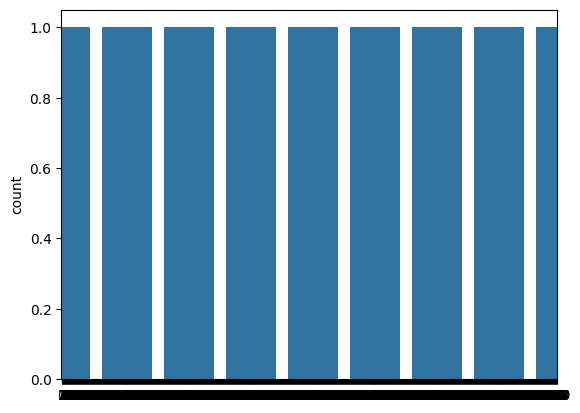

In [ ]:
sns.countplot(df.newSentiment)
#plt.xlabel('review score');

That's hugely imbalanced, but it's okay. We're going to convert the dataset into negative, neutral and positive sentiment:

In [ ]:
class_names = ['negative', 'neutral', 'positive']

In [ ]:
df.head()

,Post ID,Sound Bite Text,Sentiment,Title,Source Type,Post Type,Media Type,URL,Media Link,Domain,...,Author Location - State/Province 1,Author Location - City 1,Total Engagements,Post Comments,Post Likes,Post Shares,Post Views,Reddit Score,Cleaned Text,newSentiment
0,https://trapperman.com/forum/ubbthreads.php/to...,I take a low dose daily as counter to my metfo...,Neutrals,Warning for those who take Lisinopril - Trappe...,Forums,NaN,No Media,https://trapperman.com/forum/ubbthreads.php/to...,NaN,trapperman.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,i take a low dose daily as counter to my metfo...,2
1,1741463312586428562,@thisbttrfly @TheChiefNerd @SethMacFarlane Onl...,Neutrals,NaN,Twitter,Replies and Comments,No Media,http://twitter.com/MrShaveG/statuses/174146331...,NaN,twitter.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,thisbttrfly thechiefnerd sethmacfarlane onl...,2
2,https://www.city-data.com/forum/diabetes/34517...,Like clockwork it seems to start around 9pm in...,Neutrals,Nighttime burning itch,Forums,NaN,No Media,https://www.city-data.com/forum/diabetes/34517...,NaN,city-data.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,like clockwork it seems to start around pm in...,2
3,1741485119221674188,@HashCodeSalt @thesurepath1 I come from a medi...,Neutrals,NaN,Twitter,Replies and Comments,No Media,http://twitter.com/islam_supreme/statuses/1741...,NaN,twitter.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,hashcodesalt thesurepath i come from a medi...,2
4,https://community.whattoexpect.com/forums/may-...,Eww what a crappy doctor!!! If there was a blo...,Neutrals,Kinda freak out ? - May 2024 Babies | Forums |...,Forums,NaN,No Media,https://community.whattoexpect.com/forums/may-...,NaN,community.whattoexpect.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,eww what a crappy doctor if there was a blo...,2


<ipython-input-34-809700055606>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(class_names);


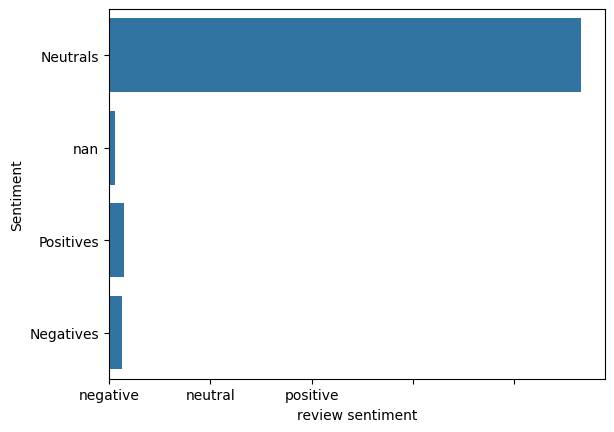

In [ ]:
ax = sns.countplot(df.Sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

The balance was (mostly) restored.

#2. What were the most important attributes or aspects being discussed? Use a Topic Modeling algorithm to extract and quantify these.

#3. What attributes were liked the most and what attributes weren’t? Describe the approach you took to compute this.

In [ ]:
import pandas as pd
import gensim
from gensim import corpora
from gensim.models import LdaModel
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer

# Assuming df is your DataFrame and 'Cleaned_Text' is the column with text data
docs = df['Cleaned_Text'].fillna('').tolist()  # Convert to list and handle NaN values

# Ensure you have the necessary NLTK resources
nltk.download('stopwords')

# Step 1: Prepare the data
# Tokenize
tokenizer = RegexpTokenizer(r'\w+')
docs_tokenized = [tokenizer.tokenize(doc.lower()) for doc in docs]

# Remove stopwords and stem
stop_words = set(stopwords.words('english'))
p_stemmer = PorterStemmer()
docs_prepared = [[p_stemmer.stem(word) for word in doc if word not in stop_words] for doc in docs_tokenized]

# Step 2 & 3: Create dictionary and corpus
dictionary = corpora.Dictionary(docs_prepared)
corpus = [dictionary.doc2bow(doc) for doc in docs_prepared]

# Step 4: Apply LDA
ldamodel = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Step 5: Analyze the results
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


(0, '0.021*"diabet" + 0.017*"diseas" + 0.010*"com" + 0.009*"cure"')
(1, '0.027*"diabet" + 0.010*"insulin" + 0.007*"get" + 0.006*"rt"')
(2, '0.021*"diabet" + 0.013*"insulin" + 0.009*"rt" + 0.008*"need"')
(3, '0.012*"diabet" + 0.010*"well" + 0.009*"health" + 0.007*"also"')
(4, '0.026*"diabet" + 0.022*"sugar" + 0.020*"blood" + 0.007*"help"')


Topics centered around diabetes management (cure, insulin usage, blood sugar levels), health and well-being, and dietary discussions (sugar intake) were prominent.

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download VADER lexicon
nltk.download('vader_lexicon')

# Initialize VADER SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Function to get the compound sentiment score for a text
def get_sentiment(row, analyzer=sia):
    return sia.polarity_scores(row)['compound']

# Function to categorize sentiment score
def categorize_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Assuming 'Cleaned_Text' is your column with textual data for analysis
# Apply sentiment scoring
df['sentiment_score'] = df['Cleaned_Text'].apply(get_sentiment)

# Categorize sentiment scores
df['sentiment_category'] = df['sentiment_score'].apply(categorize_sentiment)

# Optional: If you've assigned dominant topics to each document based on LDA output
# and wish to analyze sentiment distribution by topic, you can group by the topic
# Assuming 'dominant_topic' is a column indicating the LDA-determined topic for each document
topic_sentiment = df.groupby('dominant_topic')['sentiment_category'].value_counts(normalize=True).unstack().fillna(0)

print(topic_sentiment)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
<ipython-input-65-fa5de943f05a>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_score'] = df['Cleaned_Text'].apply(get_sentiment)
<ipython-input-65-fa5de943f05a>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_category'] = df['sentiment_score'].apply(categorize_sentiment)


KeyError: 'dominant_topic'

#4. In particular, how did consumers feel about different topics/aspects being discussed in the dataset?
Examples are “cost/price/expense” (of insulin or diabetes drugs), pharma companies,
government/public health agencies? Again, describe the approach you took to analyze this.

In [ ]:
keywords = ['cost', 'price', 'expense', 'insulin', 'pharma']
relevant_texts = df[df['Cleaned_Text'].str.contains('|'.join(keywords), case=False, na=False)]

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

relevant_texts['sentiment'] = relevant_texts['Cleaned_Text'].apply(lambda x: sia.polarity_scores(x)['compound'])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
<ipython-input-67-ed3e501e60ec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_texts['sentiment'] = relevant_texts['Cleaned_Text'].apply(lambda x: sia.polarity_scores(x)['compound'])


In [ ]:
def categorize_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

relevant_texts['sentiment_category'] = relevant_texts['sentiment'].apply(categorize_sentiment)

<ipython-input-68-08be8379ee50>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_texts['sentiment_category'] = relevant_texts['sentiment'].apply(categorize_sentiment)


In [ ]:
for keyword in keywords:
    filtered_texts = relevant_texts[relevant_texts['Cleaned_Text'].str.contains(keyword, case=False, na=False)]
    sentiment_distribution = filtered_texts['sentiment_category'].value_counts(normalize=True)
    print(f"Sentiment Distribution for {keyword}:\n{sentiment_distribution}\n")


Sentiment Distribution for cost:
Positive    0.555556
Negative    0.361111
Neutral     0.083333
Name: sentiment_category, dtype: float64

Sentiment Distribution for price:
Positive    0.65625
Negative    0.18750
Neutral     0.15625
Name: sentiment_category, dtype: float64

Sentiment Distribution for expense:
Positive    0.8
Negative    0.2
Name: sentiment_category, dtype: float64

Sentiment Distribution for insulin:
Positive    0.620438
Negative    0.299270
Neutral     0.080292
Name: sentiment_category, dtype: float64

Sentiment Distribution for pharma:
Positive    0.526316
Negative    0.473684
Name: sentiment_category, dtype: float64



#5.Quantify the type of diabetes mentioned explicitly: Type 1, Type 2 and gestational.

In [ ]:
# Keywords for searching
type1_keywords = ['type 1', 'type1', 'type I', 'T1D']
type2_keywords = ['type 2', 'type2', 'type II', 'T2D']
gestational_keywords = ['gestational diabetes', 'GDM']

# Search function
def count_mentions(text, keywords):
    return any(keyword in text for keyword in keywords)

# Creating new columns for each diabetes type mention
df['Type_1_Mention'] = df['Cleaned_Text'].apply(lambda x: count_mentions(x.lower(), type1_keywords))
df['Type_2_Mention'] = df['Cleaned_Text'].apply(lambda x: count_mentions(x.lower(), type2_keywords))
df['Gestational_Mention'] = df['Cleaned_Text'].apply(lambda x: count_mentions(x.lower(), gestational_keywords))

<ipython-input-70-10369399461d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Type_1_Mention'] = df['Cleaned_Text'].apply(lambda x: count_mentions(x.lower(), type1_keywords))
<ipython-input-70-10369399461d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Type_2_Mention'] = df['Cleaned_Text'].apply(lambda x: count_mentions(x.lower(), type2_keywords))
<ipython-input-70-10369399461d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [ ]:
type1_count = df['Type_1_Mention'].sum()
type2_count = df['Type_2_Mention'].sum()
gestational_count = df['Gestational_Mention'].sum()

print(f"Type 1 Diabetes Mentions: {type1_count}")
print(f"Type 2 Diabetes Mentions: {type2_count}")
print(f"Gestational Diabetes Mentions: {gestational_count}")


Type 1 Diabetes Mentions: 0
Type 2 Diabetes Mentions: 0
Gestational Diabetes Mentions: 30


#6. What other diseases/co-morbidities were mentioned? For example: hearth health, kidney issues,
obesity etc. How many of each?

In [ ]:
conditions_keywords = {
    'heart_health': ['heart disease', 'cardiovascular', 'heart attack'],
    'kidney_issues': ['kidney disease', 'renal failure', 'nephropathy'],
    'obesity': ['obesity', 'overweight', 'high BMI'],
    # Add more conditions and their associated keywords as needed
}

In [ ]:
def count_condition_mentions(text, condition_keywords):
    """Counts the mentions of conditions based on provided keywords."""
    condition_counts = {condition: 0 for condition in condition_keywords}
    for condition, keywords in condition_keywords.items():
        if any(keyword in text.lower() for keyword in keywords):
            condition_counts[condition] += 1
    return condition_counts

In [ ]:
# Example applying to a single aggregated text (for demonstration; adjust as needed)
aggregated_text = ' '.join(df['Cleaned_Text'])
condition_counts = count_condition_mentions(aggregated_text, conditions_keywords)

print(condition_counts)

{'heart_health': 1, 'kidney_issues': 1, 'obesity': 1}


#7. If you were to process the Twitter and non-Twitter datasets separately for some of the tasks, what are
your thoughts on the ease or accuracy of processing and analysis for these two sets? Would one set of
sources be easier or more accurate than the other? Which one?

The difference in complexity and potential accuracy:

Twitter Data: Due to the 280-character limit, tweets are concise but often use informal language, slang, and hashtags, complicating processing. However, Twitter's API facilitates data collection, and specialized NLP techniques can enhance analysis accuracy despite the brevity and informal nature of the content.

Non-Twitter Data: Longer texts from blogs or forums provide richer context and more formal language, which may align better with many NLP models, potentially improving analysis accuracy. The diversity in style and format across these sources might require more adaptable preprocessing and analysis strategies but generally allows for more detailed insights.

Ease vs. Accuracy:

Twitter data, while easily collected, presents challenges in preprocessing due to informal language. It may require more advanced techniques for accurate analysis.
Non-Twitter texts, offering more context and formality, might yield more accurate insights for tasks benefiting from detailed information, despite potential challenges in handling diverse styles and longer content.
Conclusion:
The choice between Twitter and non-Twitter datasets for analysis should consider the specific goals, the nature of the task, and the available NLP tools. Each has its advantages and requires tailored approaches to maximize the effectiveness of the analysis.


But now Twitter called X, which is not be public any more. As of the latest information available, access to X's (formerly Twitter) data for the public and researchers has become more restricted and complicated. The platform has implemented significant changes, including pricing adjustments for API access that could impact the ability to freely access and analyze X data.

## Data Preprocessing

You might already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention (good one, right?). Here are the requirements:

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides (you've guessed it) a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!


> You can use a cased and uncased version of BERT and tokenizer. I've experimented with both. The cased version works better. Intuitively, that makes sense, since "BAD" might convey more sentiment than "bad".

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [ ]:
from transformers import BertTokenizer

# Replace PRE_TRAINED_MODEL_NAME with the actual model name you're using, for example 'bert-base-uncased'
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

We'll use this text to understand the tokenization process:

In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

Some basic operations can convert the text to tokens and tokens to unique integers (ids):

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


### Special Tokens

`[SEP]` - marker for ending of a sentence


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

There is also a special token for padding:

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can be encoded using the `[UNK]` (unknown) token:

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

All of that work can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188,
        2005, 1016, 3134, 1012,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

The attention mask has the same length:

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

We can inverse the tokenization to have a look at the special tokens:

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'when',
 'was',
 'i',
 'last',
 'outside',
 '?',
 'i',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

BERT Embeddings: More recently, contextual embeddings from models like BERT (Bidirectional Encoder Representations from Transformers) have become popular. Unlike traditional word embeddings, BERT provides context-specific embeddings, meaning the representation changes based on the word's context in a sentence. This is particularly powerful for complex NLP tasks, including sentiment analysis, where understanding the context is crucial.

Contextual Embeddings: Unlike LDA, BERT is designed to capture the context of words in a sentence, using bidirectional training. This allows BERT to understand the meaning of a word based on all of its surroundings (left and right of the word). This is particularly powerful in handling nuances of language such as polysemy and context-specific meaning.

Deep Learning: BERT is based on the transformer architecture, making use of deep learning techniques. This allows it to capture complex syntactic and semantic relationships between words and phrases, outperforming simpler models on a variety of NLP tasks.
Pre-trained + Fine-tuning: BERT can be used in a two-step process where it is first pre-trained on a large corpus of text data and then fine-tuned for specific tasks with smaller datasets. This adaptability makes it incredibly versatile for a wide range of NLP applications, including sentiment analysis, question answering, and named entity recognition.

In [ ]:
token_lens = []
df.rename(columns={'Cleaned Text': 'Cleaned_Text'}, inplace=True)

for txt in df.Cleaned_Text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

<ipython-input-50-b505f1b856ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Cleaned Text': 'Cleaned_Text'}, inplace=True)


and plot the distribution:

<ipython-input-51-4dbe9bd8b56e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


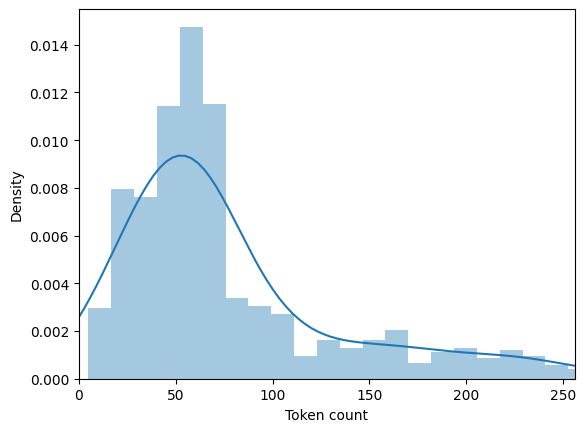

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 128 tokens, but we'll be on the safe side and choose a maximum length of 160.

In [ ]:
MAX_LEN = 160

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [ ]:
import torch
from torch.utils.data import Dataset

class GPReviewDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        review = self.dataframe.iloc[index]['Cleaned Text']
        target = self.dataframe.iloc[index]['Target Column Name']  # replace 'Target Column Name' with the actual name
        encoding = self.tokenizer.encode_plus(
          review,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
        )

        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }


The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [ ]:
RANDOM_SEED = 42  # You can choose any integer you like; 42 is a common choice
from sklearn.model_selection import train_test_split

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.Cleaned_Text.to_numpy(),
    targets=df.newSentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

TypeError: GPReviewDataset.__init__() got an unexpected keyword argument 'reviews'

Let's have a look at an example batch from our training data loader:

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else.

But who cares, right? We're *hardcore*! We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

And try to use it on the encoding of our sample text:

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [ ]:
last_hidden_state.shape

torch.Size([1, 32, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [ ]:
bert_model.config.hidden_size

768



You can think of the `pooled_output` as a summary of the content, according to BERT. Albeit, you might try and do better. Let's look at the shape of the output:

In [ ]:
pooled_output.shape

torch.Size([1, 768])

We can use all of this knowledge to create a classifier that uses the BERT model:

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5879, 0.0842, 0.3279],
        [0.4308, 0.1888, 0.3804],
        [0.4871, 0.1766, 0.3363],
        [0.3364, 0.0778, 0.5858],
        [0.4025, 0.1040, 0.4935],
        [0.3599, 0.1026, 0.5374],
        [0.5054, 0.1552, 0.3394],
        [0.5962, 0.1464, 0.2574],
        [0.3274, 0.1967, 0.4759],
        [0.3026, 0.1118, 0.5856],
        [0.4103, 0.1571, 0.4326],
        [0.4879, 0.2121, 0.3000],
        [0.3811, 0.1477, 0.4712],
        [0.3354, 0.1354, 0.5292],
        [0.3999, 0.2822, 0.3179],
        [0.5075, 0.1684, 0.3242]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.7330631300571541 accuracy 0.6653729447463129
Val   loss 0.5767546480894089 accuracy 0.7776365946632783

Epoch 2/10
----------
Train loss 0.4158683338330777 accuracy 0.8420012701997036
Val   loss 0.5365073362737894 accuracy 0.832274459974587

Epoch 3/10
----------
Train loss 0.24015077009679367 accuracy 0.922023851527768
Val   loss 0.5074492372572422 accuracy 0.8716645489199493

Epoch 4/10
----------
Train loss 0.16012676668187295 accuracy 0.9546962105708843
Val   loss 0.6009970247745514 accuracy 0.8703939008894537

Epoch 5/10
----------
Train loss 0.11209654617575301 accuracy 0.9675393409074872
Val   loss 0.7367783848941326 accuracy 0.8742058449809403

Epoch 6/10
----------
Train loss 0.08572274737026433 accuracy 0.9764307388328276
Val   loss 0.7251267762482166 accuracy 0.8843710292249047

Epoch 7/10
----------
Train loss 0.06132202987342602 accuracy 0.9833462705525369
Val   loss 0.7083295831084251 accuracy 0.889453621346887

Epoch 8/10
----------
Tra

Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy:

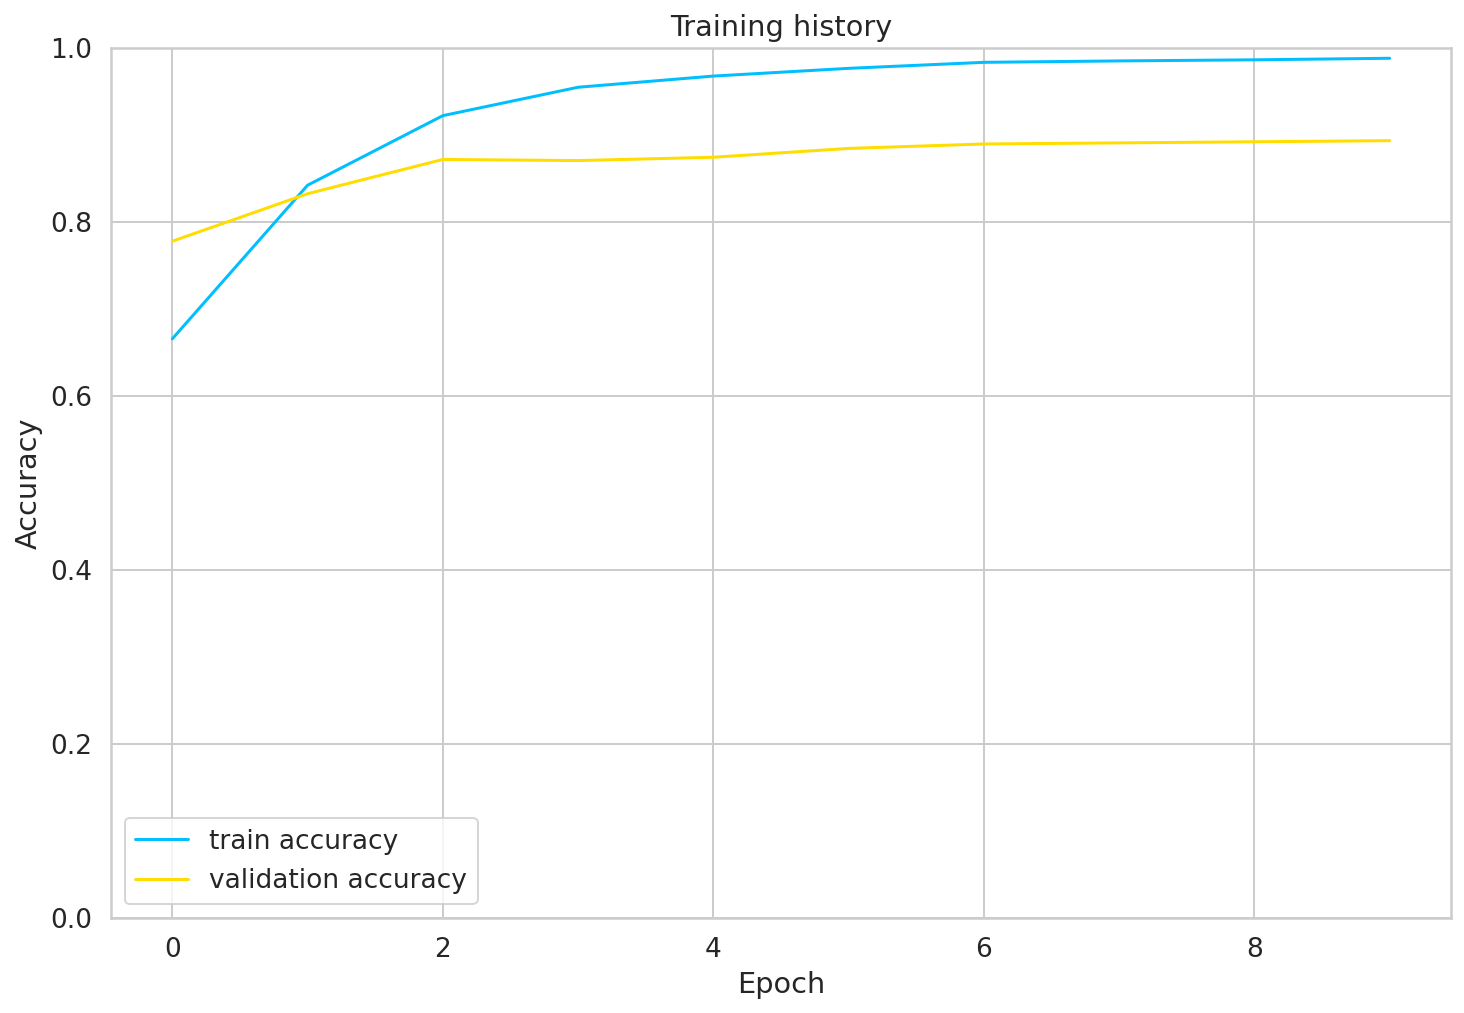

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

The training accuracy starts to approach 100% after 10 epochs or so. You might try to fine-tune the parameters a bit more, but this will be good enough for us.

Don't want to wait? Uncomment the next cell to download my pre-trained model:

In [ ]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

# model = SentimentClassifier(len(class_names))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

## Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.883248730964467

The accuracy is about 1% lower on the test set. Our model seems to generalize well.

We'll define a helper function to get the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let's have a look at the classification report

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.89      0.87      0.88       245
     neutral       0.83      0.85      0.84       254
    positive       0.92      0.93      0.92       289

    accuracy                           0.88       788
   macro avg       0.88      0.88      0.88       788
weighted avg       0.88      0.88      0.88       788



Looks like it is really hard to classify neutral (3 stars) reviews. And I can tell you from experience, looking at many reviews, those are hard to classify.

We'll continue with the confusion matrix:

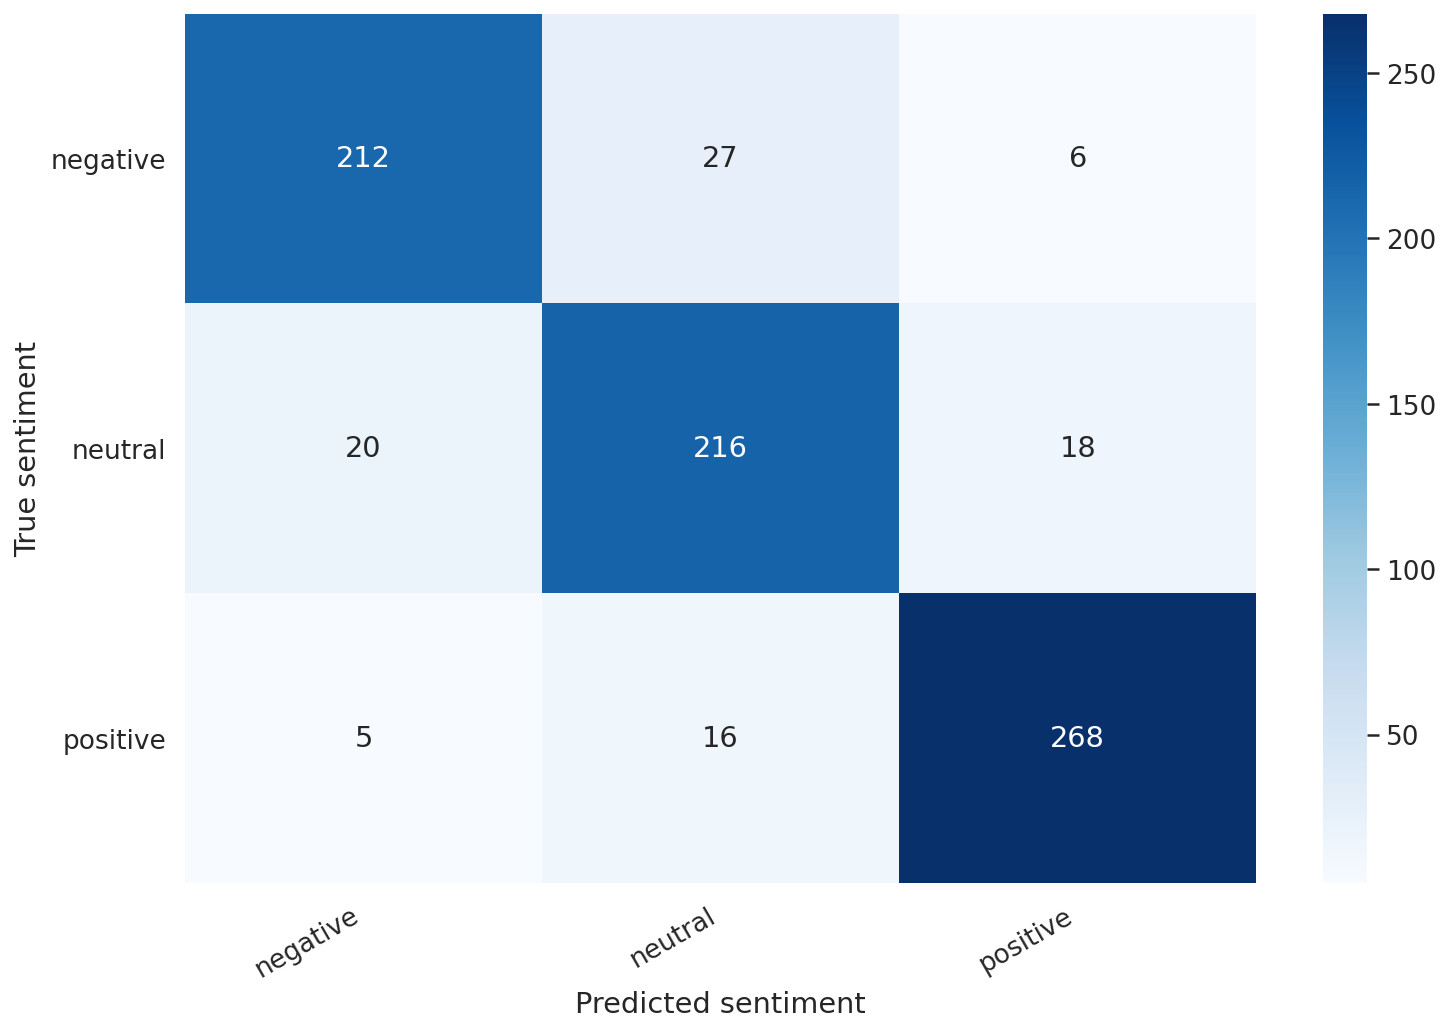

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

I used to use Habitica, and I must say this is a great step up. I'd
like to see more social features, such as sharing tasks - only one
person has to perform said task for it to be checked off, but only
giving that person the experience and gold. Otherwise, the price for
subscription is too steep, thus resulting in a sub-perfect score. I
could easily justify $0.99/month or eternal subscription for $15. If
that price could be met, as well as fine tuning, this would be easily
worth 5 stars.

True sentiment: neutral


Now we can look at the confidence of each sentiment of our model:

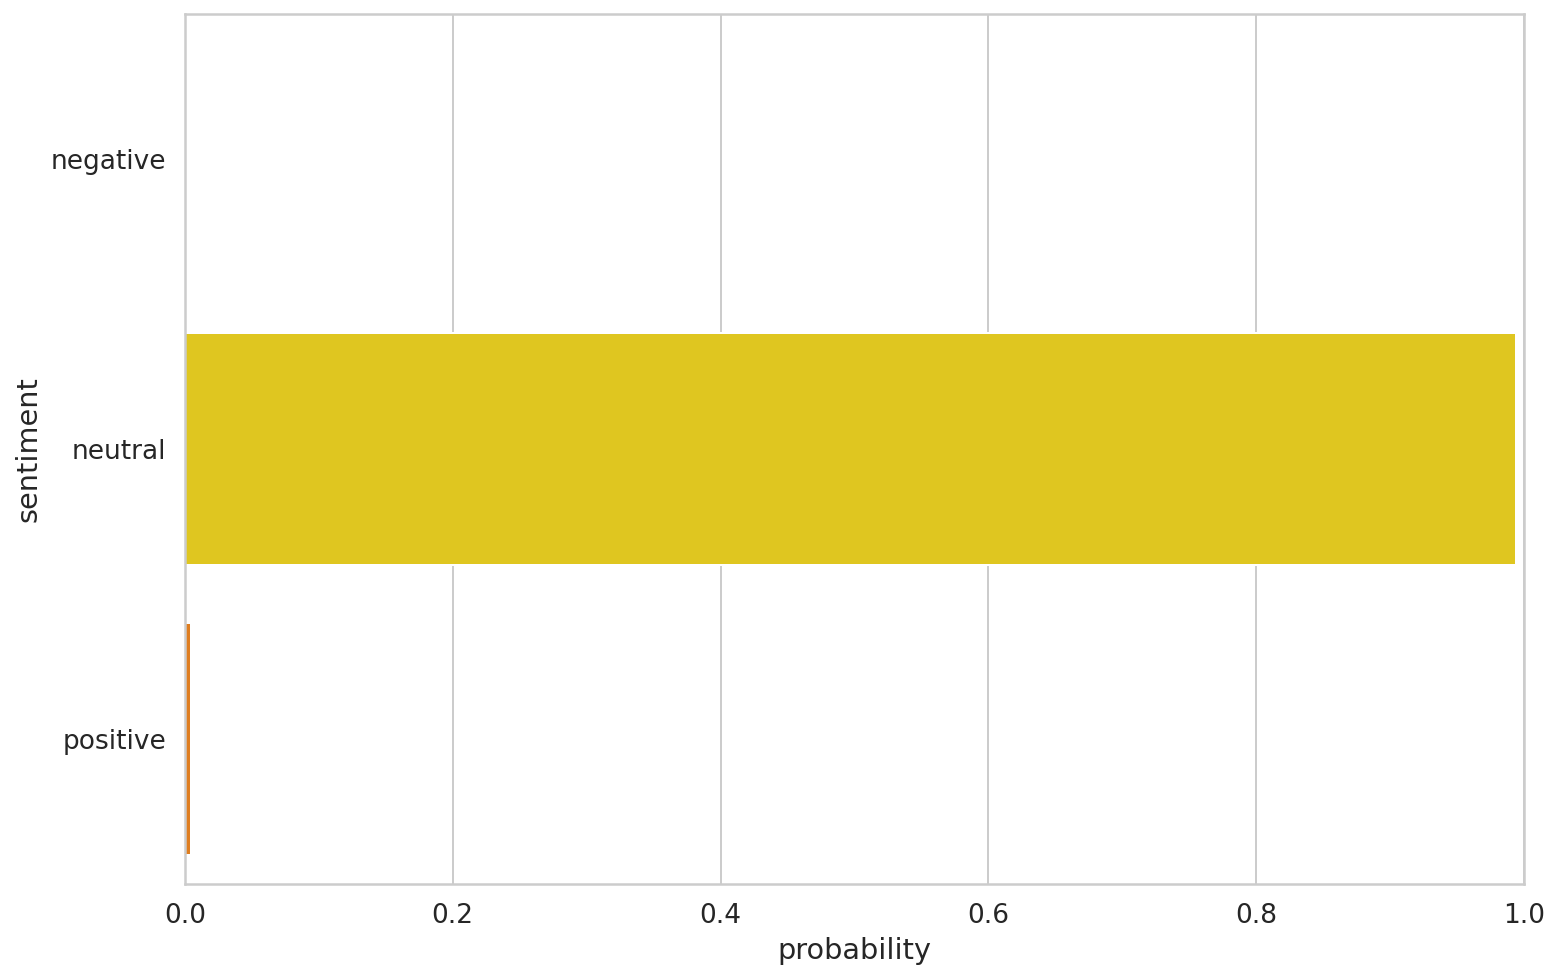

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

We have to use the tokenizer to encode the text:

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Let's get the predictions from our model:

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive


## Summary

Nice job! You learned how to use BERT for sentiment analysis. You built a custom classifier using the Hugging Face library and trained it on our app reviews dataset!

- [Read the tutorial](https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S)
- [Read the `Getting Things Done with Pytorch` book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You learned how to:

- Intuitively understand what BERT is
- Preprocess text data for BERT and build PyTorch Dataset (tokenization, attention masks, and padding)
- Use Transfer Learning to build Sentiment Classifier using the Transformers library by Hugging Face
- Evaluate the model on test data
- Predict sentiment on raw text

Next, we'll learn how to deploy our trained model behind a REST API and build a simple web app to access it.

## References

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [L11 Language Models - Alec Radford (OpenAI)](https://www.youtube.com/watch?v=BnpB3GrpsfM)
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [Huggingface Transformers](https://huggingface.co/transformers/)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)